<a href="https://colab.research.google.com/github/strongway/tutorial_data_science/blob/master/Cog_Modeling_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cognitive modeling (1)

## Introduction to probabilistic programming with PyMC3

13th Dec. 2021

Strongway

PyMC3 is a Python library for prbabilistic programming. PyMC3 provides a very simple and intuitive syntax that is easy to read and model. 

Some tutorial materials included here are adapted from the books *[Bayesian Analysis with Python](https://)* (2nd Edition) by Osvaldo Martin ([github code](https://github.com/aloctavodia/BAP))and *[Bayesian cognitive modeling](http://bayesmodels.com/)* by Michael Lee and Eric-Jan Wagenmakers ([code here](https://github.com/pymc-devs/resources/tree/master/BCM)).  

In [1]:
#we will use bambi later on
!pip install bambi

     |████████████████████████████████| 67 kB 3.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import arviz as az
import warnings
import seaborn as sns
import scipy 

from scipy import stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

print(pm.__version__)
print(scipy.__version__)

3.11.4
1.7.3


## Example 1 - the seven scientists

This example was first mentioned by MacKay about dealing with extreme values with Bayesian approach. 

Seven scientists with widely-differing experimental skills all make a measurement of the same quantity. They get the answers 

$$x=\{−27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056\}.$$ 

Intuitively, it seems clear that the first two are pretty inept measureers. The standard approach in experimental psychology we usually treat them as outliers and excluded for further analysis. 

Note, the main inference we want to draw is the **population mean and standard deviation**. 
We can assume all the scientists have measurements that follow a Gaussian distribution, but with *different* standard deviations. Because they are all measuring the same quantity, each Gaussian has the same mean, but differs in the standard deviation. 

$$x_i \sim N(\mu, \sigma_i)$$



### probabilistic thinking of the parameters

In a standard approach, we estimate those parameters (i.e., $\mu, \sigma_i$) from the data. In the probabilitic programming, we treat those parameters as random variables, each has its own distribution (prior distributions). So the above prameter $\mu$ is assumed to follow Gaussian distribution, and $\sigma_i$ follows Half-normal distribution.

There is alterantive approach, which suggested by Gelman. Instead of using the standard deviation $\sigma$, we can also use the precision $\tau$. The relation is as follows:

$$\tau = 1/\sigma^2$$

Using a gamma distribution for the priors on the precision is a standard approach proposed by Gelman (2006). Gamma distribution is non-negative distribution:

![Gamma](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/650px-Gamma_distribution_pdf.svg.png)

Back to the above seven scientist example, we can assume

$$\mu \sim N(0, 0.001)$$
$$\tau_i \sim Gamma(0.001, 0.001)$$
or 
$$\sigma_i \sim HalfNormal(10)$$




### Model specification in PyMC3

In PyMC3, specifying models is straightforward because the syntax is as close to the statistical notation. 

First, we need to initiate a model, using `pm.Model()`, to a model variable. Then within this model variable, we can specify those priors for unknown parameters. For the above example, we can write as follows:

In [ ]:
# data
x = np.array([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])
n = len(x)

with pm.Model() as basic_model:
    # prior
    mu = pm.Normal("mu", mu=0., tau=0.01)
    lambda_i = pm.Gamma("lambda_i", alpha=0.01, beta=0.01, shape=n)
    # sigma = pm.Deterministic('sigma',1 / sqrt(lambda1))
    # observed
    xi = pm.Normal("xi", mu=mu, tau=lambda_i, observed=x)


Following instantiation of the omdel, the subequent specifications of the model components is performed inside a `with` statement. This creates a _context manager_, with the basic_model as the context, that includes includes all statements untile the indented block ends. This means all PyMC3 objects introduced in the indeted code block below the with statement are added to the model behind the scenes. 

Note, the above $\lambda_i$ has an additonal shape argument to denote it as a vector0valued parameter of size 8 (scientists). 

The final lineof the model, defines the observed data. This is a special case of a stochastic variable that we call an observed stochastic, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.

### Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the maximum a posteriori (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### Maximum a posteriori methods

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

Below we find the MAP for our original model. The MAP is returned as a parameter point, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.



In [ ]:
map_estimate = pm.find_MAP(model = basic_model)
map_estimate

{'lambda_i': array([2.13992396e-180, 0.00000000e+000, 0.00000000e+000, 3.95252517e-323,
        0.00000000e+000, 9.78249979e-322, 2.12297538e-318]),
 'lambda_i_log__': array([ -413.70454644, -1022.52966171,  -773.88453496,  -742.42162749,
         -763.2169327 ,  -739.15013925,  -731.46924214]),
 'mu': array(53.64044131)}

Let's try another model with standard sigma parameter. 

In [ ]:
with pm.Model() as model2:
    # prior
    mu = pm.Normal("mu", mu=0., tau=0.01)
    sigma_i = pm.HalfNormal("sigma_i",sigma = 100 , shape=n)
    # observed
    xi = pm.Normal("xi", mu=mu, sigma=sigma_i, observed=x)
    map_estimate = pm.find_MAP()

map_estimate

{'mu': array(3.57),
 'sigma_i': array([3.51515661e+01, 2.53315511e-08, 5.09979006e+00, 5.26420193e+00,
        4.99886283e+00, 5.30731442e+00, 5.30934118e+00]),
 'sigma_i_log__': array([  3.55966917, -17.49121514,   1.62919937,   1.66092955,
          1.60921045,   1.66908595,   1.66946776])}

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module. 

With such extreme small dataset and extreme data, the MAP method is subject to large variable by the parameters you specified in the prior distribution. 

In addition,  it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the true posterior distribution.

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods submodule contains the following samplers: `NUTS`, `Metropolis`, `Slice`, `HamiltonianMC`, and `BinaryMetropolis`. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

- Binary variables will be assigned to BinaryMetropolis
- Discrete variables will be assigned to Metropolis
- Continuous variables will be assigned to NUTS

In [ ]:
with basic_model:
  #inference using MCMC
  trace = pm.sample(2000, tune = 2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda_i, mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [ ]:
idata = az.from_pymc3(trace)
az.summary(idata)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.866,0.220,9.509,10.236,0.008,0.006,1247.0,918.0,1.0
lambda_i[0],0.001,0.001,0.000,0.003,0.000,0.000,1878.0,1200.0,1.0
lambda_i[1],0.026,0.035,0.000,0.089,0.001,0.000,2041.0,1079.0,1.0
lambda_i[2],0.448,1.756,0.000,1.329,0.064,0.045,1746.0,1575.0,1.0
lambda_i[3],31.091,52.135,0.000,117.975,0.914,0.646,1686.0,1595.0,1.0
lambda_i[4],14.688,29.559,0.000,57.324,0.553,0.391,1891.0,1656.0,1.0
lambda_i[5],30.695,49.749,0.000,117.426,0.910,0.661,1520.0,1370.0,1.0
lambda_i[6],23.190,39.754,0.000,93.958,0.756,0.534,1163.0,1166.0,1.0


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a Trace object containing the samples collected, in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the mu variable as follows:



In [ ]:
trace['mu'][-5:]

array([9.82333053, 9.86462572, 9.86006706, 9.7693979 , 9.57452618])

### Posterior analysis

PyMC3’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named ArviZ. A simple posterior plot can be created using plot_trace.



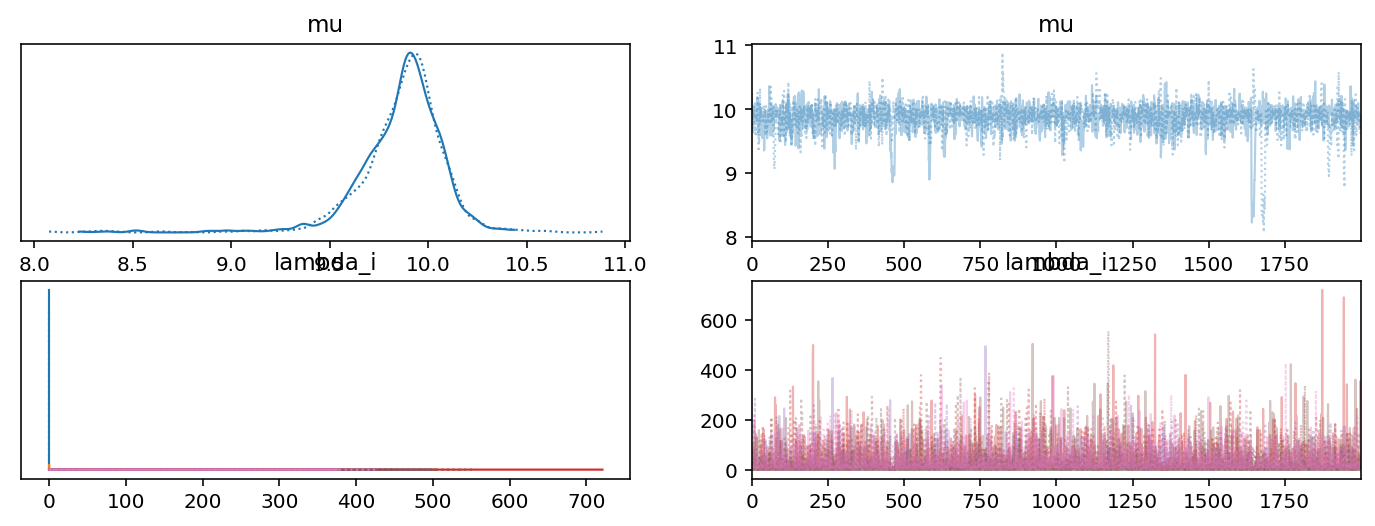

In [ ]:
az.plot_trace(idata);

In [ ]:
x

array([-27.02 ,   3.57 ,   8.191,   9.898,   9.603,   9.945,  10.056])

In [ ]:
# if we use outlier exclusion approach
np.mean(x[2:])

9.538599999999999

## Example 2 - linear model

With most statistical software, you can easily estimate the coefficients of a standard linear model. Such easy approach makes us often forgot the stochastic nature of the linear model. 

A linear model has a stochastic component $\epsilon$ which follows Gaussian distribution. 

$$y = ax + b + \epsilon$$

That is, we assume

$$ y \sim N(ax+b, \sigma^2)$$



In [ ]:
# let's create some hypothetical observed data
n = 50
_a = 1.5
_b = 3
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

with pm.Model() as model:
    a = pm.Normal('a', mu=0, sd=20)
    b = pm.Normal('b', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = a*x + b # simple auxiliary variables

    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)


In [ ]:
with model:    # inference
    trace = pm.sample(2000)
az.summary(az.from_pymc3(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.814,0.522,0.838,2.812,0.012,0.009,1865.0,2093.0,1.0
b,2.892,0.306,2.331,3.480,0.007,0.005,1903.0,2031.0,1.0
sigma,1.101,0.119,0.868,1.309,0.003,0.002,1740.0,1679.0,1.0


### Generalized Linear Models (GLM)
Generalized Linear Models (GLMs) are a class of flexible models that are widely used to estimate regression relationships between a single outcome variable and one or multiple predictors. Because these models are so common, PyMC3 offers a glm submodule that allows flexible creation of various GLMs with an intuitive R-like syntax that is implemented via the patsy module.

The glm submodule requires data to be included as a pandas DataFrame. Hence, for our linear regression example:



In [ ]:
# convert x and y to dataframe
df = pd.DataFrame({'x':x, 'y':y})

The model can then be very concisely specified in one line of code.

In [ ]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula("y ~ x", df)
    trace = pm.sample()


The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


In [ ]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.896,0.319,2.322,3.531,0.011,0.007,913.0,933.0,1.0
x,1.806,0.542,0.837,2.848,0.018,0.013,910.0,858.0,1.0
sd,1.102,0.115,0.899,1.326,0.003,0.002,1259.0,1020.0,1.0


###  Bayesian model-building interface (Bambi)

Bambi is a high-level Bayesian model-building interface written in Python. It works with the probabilistic programming frameworks PyMC3 and is designed to make it extremely easy to fit Bayesian mixed-effects models common in biology, social sciences and other disciplines.



In [3]:
import bambi as bmb

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.827,0.252,2.340,3.293,0.004,0.003,4916.0,2796.0,1.0
x,1.286,0.428,0.452,2.060,0.006,0.004,5158.0,2780.0,1.0
y_sigma,0.887,0.092,0.724,1.061,0.001,0.001,4463.0,2935.0,1.0


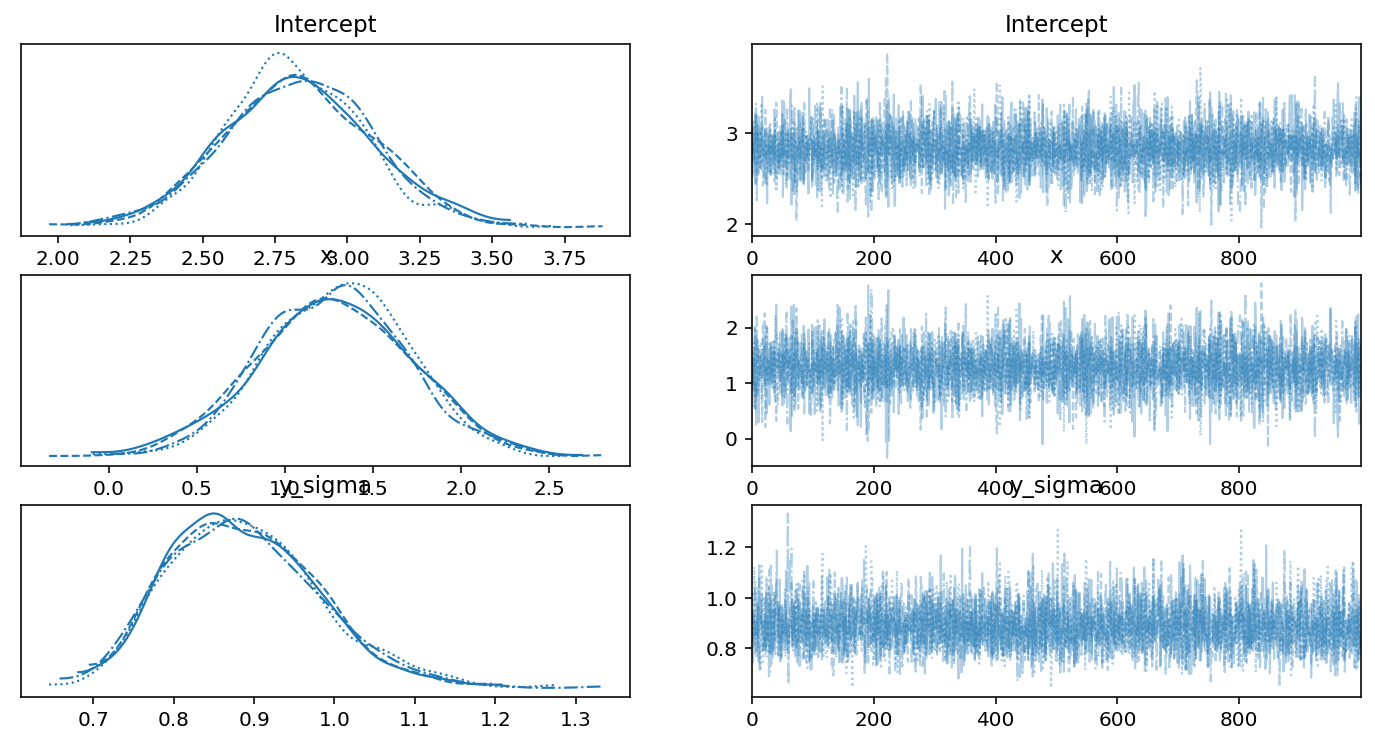

In [ ]:
# Initialize the fixed effects only model
model = bmb.Model('y ~ x', df)

# Fit the model using 1000 on each of 4 chains
results = model.fit(draws=1000, chains=4)

# Use ArviZ to plot the results
az.plot_trace(results)

# Key summary and diagnostic info on the model parameters
az.summary(results)


__Chain__ in PyMC3

A chian is a single run of MCMC. When running MCMC, it is a best practice to use multiple chains, as they can help diagnose problems 0 such as convergence. 


__Compared to standard linear model__

For the simple linear regression, you may find the standard approach is much easier (see blow). However, when we go for mixed models and hierarchical models, you will see advantages from PyMC3. 

In [7]:
# standard approach with statsmodel

import statsmodels.api as sm
import statsmodels.formula.api as smf

#let's visualize the hypothetical data
sns.lmplot(data = df, x = 'x', y = 'y')

NameError: ignored

In [ ]:
model3 = smf.ols(formula = 'y ~ x', data = df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     9.559
Date:                Mon, 13 Dec 2021   Prob (F-statistic):            0.00331
Time:                        08:53:15   Log-Likelihood:                -63.153
No. Observations:                  50   AIC:                             130.3
Df Residuals:                      48   BIC:                             134.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8228      0.243     11.600      0.000       2.333       3.312
x              1.2966      0.419      3.092      0.003       0.453       2.140
==============================================================================
Omnibus:                        0.726   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.696   Jarque-Bera (JB):                0.719
Skew:                          -0.268   Prob(JB):                        0.698
Kurtosis:                       2.758   Cond. No.                         4.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Example 3: contextual cueing and procedual learning

Here we use our recent published multisensory contextual study by Siyi for an illustration:

* Chen, S., Shi, Z., Müller, H. J., & Geyer, T. (2021). Multisensory visuo-tactile context learning enhances the guidance of unisensory visual search. Scientific Reports, 11(1), 9439. https://doi.org/10.1038/s41598-021-88946-6 

In this study, we comapred multisensory learning in different configurations (Old vs. New) and different multisensory environments. The original study used hierarchical drift-diffusion model (HDDM) and partial pooling methods to estimated HDDM parameters, which is a bit more complex than we do here. We may do another session on DDM models. 

Here we only illustrate that we can also estimate behavioral data using simple linear regression to interpret the findings. 

The behavioral results look like this:

![cc](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-021-88946-6/MediaObjects/41598_2021_88946_Fig5_HTML.png?as=webp)

The standard approach to test if there are any effects and interactions, we use 'ANOVA'! Given that Epoch is a continuous variable, let's think differently. 

   subj_idx condition  epoch        rt
0         1   v_v_new      1  1.517301
1         1   v_v_new      2  0.920525
2         1   v_v_new      3  0.864780
3         1   v_v_new      4  1.048344
4         1   v_v_new      5  0.911363


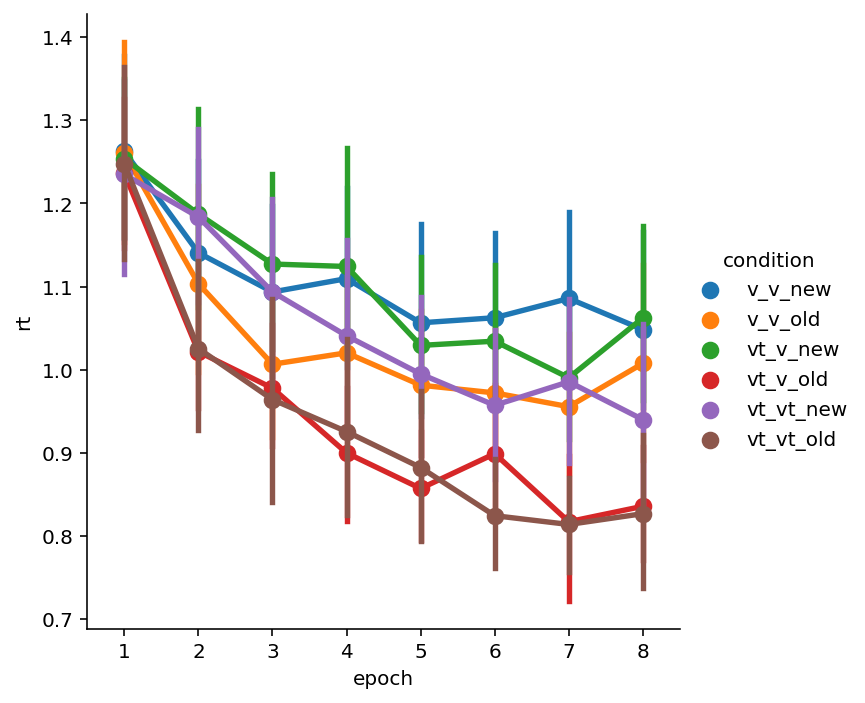

In [4]:
# first load data and visualize it. 
data = pd.read_csv('https://osf.io/58wqy/download')
mdata = data.groupby(['subj_idx','condition','epoch']).rt.mean().reset_index()
print(mdata.head())
sns.catplot(data = mdata, kind = 'point', 
                    x = 'epoch', y = 'rt', hue = 'condition')


The above figure shows the typical procedual learning effect. Intially the reaction was slow, and gradually became faster and reach some platue. In the original paper, we use exponential function to capture this $RT = RT_0 + \Delta e^{-\alpha N} $, where $N$ is the epoch number. 

 Here we do another approach: log-tranform of the epoch. The idea behind this is that the learning benefits reduces as the number of epochs increases. Thus, to get the same ammount of reduction in RT, you need more epochs (number of blocks).

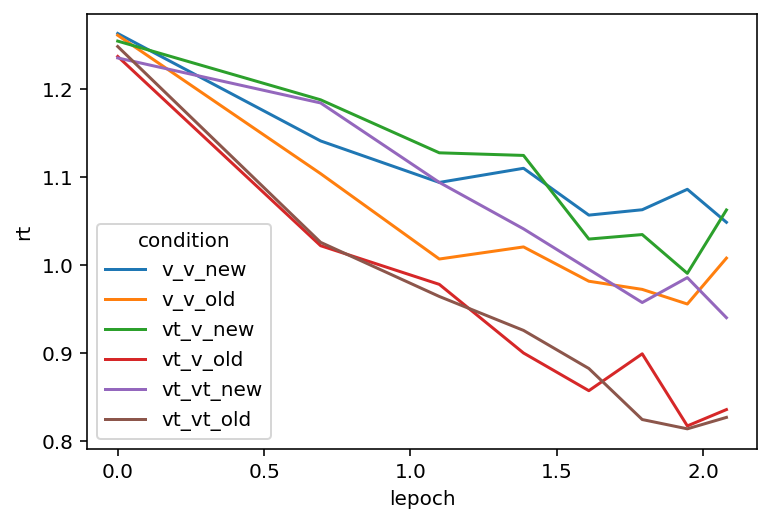

In [5]:
#if we plot in log-scale for x-axis
mdata['lepoch']  = np.log(mdata.epoch)
mm = mdata.groupby(['lepoch','condition']).rt.mean().reset_index()
f = sns.lineplot(data = mm, 
                    x = 'lepoch', y = 'rt', hue = 'condition')
plt.show()

To model the both conditions, we should first assume what kind of linear models would be. 

* One could assume that the 'old' vs. 'new' did not differ in the learning rate, but differ in the intercept. 
* one could assume there was interaction between the context (old/new) and procedual learning (epochs). 

The first hypothesis would be:

$$RT = a_0 + a_{d} + b \cdot ln(Epoch), $$
where $a_d$ is the difference between the old and new. 

The second hypothesis would be:

$$RT = a_0 + a_{d} + (b_0+b_d) \cdot ln(Epoch), $$
where $b_d$ is the difference in the slope between two conditions. 

### Syntax of R-Type formula. 

A formulas is an unevaluated expression, which denotes the relationships between the independent variables and dependent variables. The relationship uses the symbol `~`. On the left side is the dependent variable, while on the right side is the independent variables. For example,

` y ~ x` is the simple linear regression. 

If you have two independent variables, and they are independent with each other, you use `+` symbol.

`y ~ x + z`

When you want to include their interaction (using `:` symbol), the formula would be:

`y ~ x + z + x:z`

For simplicity, the above formula can be simplified as 

` y ~ x*z` (i.e., including main factors and their interactions). 



In [8]:
# apply linear regression (assumption with interactions)
model1 = smf.ols(formula = 'rt ~ lepoch*condition', data = mdata).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     24.19
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           4.57e-42
Time:                        09:25:36   Log-Likelihood:                 161.23
No. Observations:                 672   AIC:                            -298.5
Df Residuals:                     660   BIC:                            -244.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.2286      0.041     30.097      0.000       1.148       1.309
condition[T.v_v_old]             -0.0175      0.058     -0.303      0.762      -0.131       0.096
condition[T.vt_v_new]             0.0298      0.058      0.516      0.606      -0.084       0.143
condition[T.vt_v_old]            -0.0356      0.058     -0.616      0.538      -0.149       0.078
condition[T.vt_vt_new]            0.0249      0.058      0.431      0.666      -0.088       0.138
condition[T.vt_vt_old]           -0.0211      0.058     -0.365      0.715      -0.134       0.092
lepoch                           -0.0915      0.028     -3.316      0.001      -0.146      -0.037
lepoch:condition[T.v_v_old]      -0.0388      0.039     -0.995      0.320      -0.115       0.038
lepoch:condition[T.vt_v_new]     -0.0272      0.039     -0.698      0.485      -0.104       0.049
lepoch:condition[T.vt_v_old]     -0.0971      0.039     -2.490      0.013      -0.174      -0.021
lepoch:condition[T.vt_vt_new]    -0.0592      0.039     -1.518      0.130      -0.136       0.017
lepoch:condition[T.vt_vt_old]    -0.1113      0.039     -2.853      0.004      -0.188      -0.035
==============================================================================
Omnibus:                       30.778   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.382
Skew:                           0.504   Prob(JB):                     3.42e-08
Kurtosis:                       3.462   Cond. No.                         31.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note, in the above regression, we have categorical variable `condition` (Old and New). In the linear regression, the categorical variable will first be translated into dummy variable(s). Here:

$$RT = a_0 + a_{old} + (b_0 + b_{old})\cdot ln(\text{Epoch})$$

That is, it assumes the new and old have different intercepts and slopes. The 'new' condition has $a_0$ and $b_0$, while the 'old' has $a_0 + a_{old}$ and $b_0 + b_{old}$. 



In [ ]:
#  The above model shows the intercept are not significantly differ from each, we remove it
model2 = smf.ols(formula = 'rt ~ lepoch + lepoch:condition', data = mdata).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     rt   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     44.20
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           1.59e-45
Time:                        09:11:45   Log-Likelihood:                 160.17
No. Observations:                 672   AIC:                            -306.3
Df Residuals:                     665   BIC:                            -274.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.2254      0.017     73.689      0.000       1.193       1.258
lepoch                           -0.0895      0.016     -5.650      0.000      -0.121      -0.058
lepoch:condition[T.v_v_old]      -0.0494      0.017     -2.855      0.004      -0.083      -0.015
lepoch:condition[T.vt_v_new]     -0.0092      0.017     -0.532      0.595      -0.043       0.025
lepoch:condition[T.vt_v_old]     -0.1186      0.017     -6.855      0.000      -0.153      -0.085
lepoch:condition[T.vt_vt_new]    -0.0441      0.017     -2.551      0.011      -0.078      -0.010
lepoch:condition[T.vt_vt_old]    -0.1241      0.017     -7.168      0.000      -0.158      -0.090
==============================================================================
Omnibus:                       30.975   Durbin-Watson:                   0.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.594
Skew:                           0.506   Prob(JB):                     3.08e-08
Kurtosis:                       3.458   Cond. No.                         8.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Mixed model

In the standard linear regression, all data points are treated as independent. However, in most behavioral studies, we have within-subject design, which help us to disassoicate the individual difference from the main manipulation. 

The linear mixed model includes unique effects for individual subjects, which can extract those individual difference from the parameters estimates. 

Consider a simple regression,

$$Y = a + b X + \epsilon$$

If we assume the intercept may varY among participants, but individual differences may cancel out each other in the group-level intercept, we have the following mixed model:

$$ Y = a + a_{ind} + bX  + \epsilon,$$

where $a_{ind} \sim N(0, \sigma_a)$. 

If we further assume that individuals have different slopes as well, we will have

$$Y = a + a_{ind} + (b + b_{ind})X  + \epsilon,$$
where  $b_{ind} \sim N(0, \sigma_b)$.

In [9]:
# mixed model: Intercept difference
mix1 = smf.mixedlm('rt ~ lepoch + lepoch:condition', data = mdata, 
                   groups = mdata.subj_idx)
res1 = mix1.fit()
res1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                  MixedLM       Dependent Variable:       rt      
No. Observations:       672           Method:                   REML    
No. Groups:             14            Scale:                    0.0240  
Min. group size:        48            Likelihood:               255.4338
Max. group size:        48            Converged:                Yes     
Mean group size:        48.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      1.225    0.034 36.173 0.000  1.159  1.292
lepoch                        -0.090    0.013 -6.985 0.000 -0.115 -0.064
lepoch:condition[T.v_v_old]   -0.049    0.014 -3.529 0.000 -0.077 -0.022
lepoch:condition[T.vt_v_new]  -0.009    0.014 -0.658 0.511 -0.037  0.018
lepoch:condition[T.vt_v_old]  -0.119    0.014 -8.475 0.000 -0.146 -0.091
lepoch:condition[T.vt_vt_new] -0.044    0.014 -3.153 0.002 -0.072 -0.017
lepoch:condition[T.vt_vt_old] -0.124    0.014 -8.862 0.000 -0.151 -0.097
Group Var                      0.014    0.036                           
========================================================================

"""

### Linear mixed model with Bambi

The formula specification in Bambi is very similar to what we use in R. 

In [10]:
model = bmb.Model('rt ~ lepoch + lepoch:condition + (1|subj_idx)', data = mdata)
results = model.fit()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rt_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, Intercept, lepoch:condition, lepoch]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.224,0.041,1.142,1.295,0.002,0.002,305.0,191.0,1.01
lepoch,-0.089,0.013,-0.112,-0.065,0.000,0.000,811.0,1087.0,1.00
lepoch:condition[v_v_old],-0.050,0.014,-0.075,-0.021,0.000,0.000,989.0,1229.0,1.00
lepoch:condition[vt_v_new],-0.010,0.014,-0.039,0.015,0.000,0.000,824.0,1043.0,1.00
lepoch:condition[vt_v_old],-0.119,0.014,-0.145,-0.093,0.000,0.000,961.0,1060.0,1.00
lepoch:condition[vt_vt_new],-0.045,0.015,-0.073,-0.019,0.000,0.000,882.0,1200.0,1.00
lepoch:condition[vt_vt_old],-0.124,0.014,-0.150,-0.098,0.000,0.000,900.0,1196.0,1.00
1|subj_idx_sigma,0.135,0.036,0.080,0.194,0.003,0.002,298.0,240.0,1.01
1|subj_idx[1],-0.021,0.045,-0.101,0.063,0.003,0.002,328.0,244.0,1.01
1|subj_idx[2],-0.090,0.045,-0.173,-0.004,0.003,0.002,320.0,230.0,1.00


In [12]:
model

Formula: rt ~ lepoch + lepoch:condition + (1|subj_idx)
Family name: Gaussian
Link: identity
Observations: 672
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.0304, sigma: 1.3612)
    lepoch ~ Normal(mu: 0.0, sigma: 0.8568)
    lepoch:condition ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [1.0025 1.0025 1.0025 1.0025 1.0025])

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.3612))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2255)


------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [26]:
model1 = bmb.Model('rt ~ lepoch + (lepoch|condition) + (1|subj_idx)', data = mdata)
model1

Formula: rt ~ lepoch + (lepoch|condition) + (1|subj_idx)
Family name: Gaussian
Link: identity
Observations: 672
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.0304, sigma: 1.2679)
    lepoch ~ Normal(mu: 0.0, sigma: 0.8568)

  Group-level effects
    1|condition ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2679))
    lepoch|condition ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.8568))
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2679))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2255)


We want to have a main procedual learning slope, and also allow a each condition has its own slope, and a general variation among subjects. 


In [27]:
results1 = model1.fit()
tab1 = az.summary(results1)
tab1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rt_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, lepoch|condition_offset, lepoch|condition_sigma, 1|condition_offset, 1|condition_sigma, Intercept, lepoch]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 119 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.226,0.041,1.148,1.298,0.002,0.002,294.0,560.0,1.00
lepoch,-0.149,0.027,-0.206,-0.101,0.001,0.001,344.0,591.0,1.00
1|condition_sigma,0.029,0.023,0.000,0.070,0.001,0.001,555.0,499.0,1.01
1|condition[v_v_new],0.004,0.024,-0.037,0.054,0.001,0.001,219.0,94.0,1.01
1|condition[v_v_old],-0.003,0.022,-0.043,0.040,0.001,0.001,609.0,384.0,1.00
1|condition[vt_v_new],0.016,0.024,-0.020,0.068,0.001,0.001,1010.0,1002.0,1.00
1|condition[vt_v_old],-0.017,0.025,-0.070,0.027,0.001,0.001,825.0,744.0,1.00
1|condition[vt_vt_new],0.012,0.024,-0.031,0.059,0.001,0.001,409.0,278.0,1.01
1|condition[vt_vt_old],-0.011,0.022,-0.058,0.028,0.001,0.001,905.0,1269.0,1.00
lepoch|condition_sigma,0.069,0.040,0.021,0.140,0.006,0.005,123.0,40.0,1.01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9c6c7be50>,
      dtype=object)

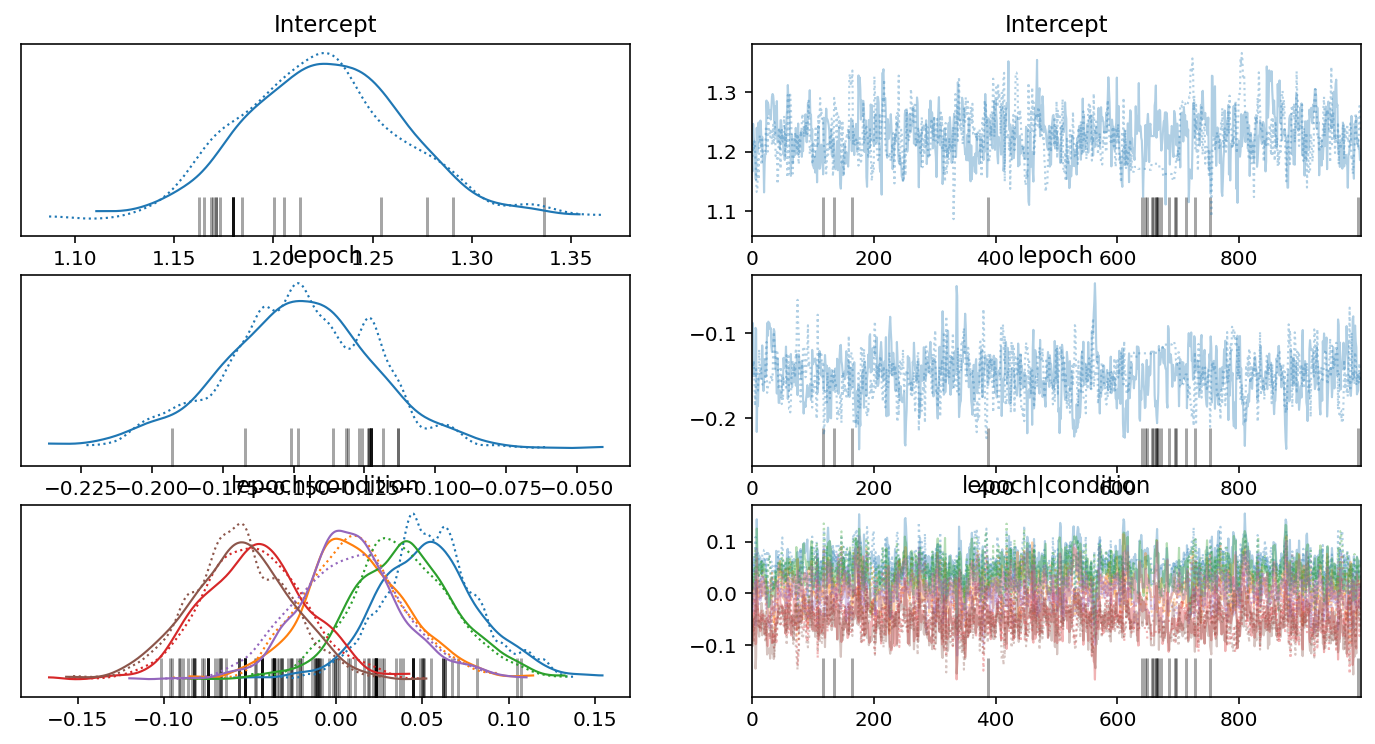

In [28]:
az.plot_trace(results1,
              var_names = ['Intercept','lepoch','lepoch|condition'])

In [34]:
tab1[10:17]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lepoch|condition[v_v_new],0.055,0.029,0.005,0.117,0.001,0.001,545.0,708.0,1.01
lepoch|condition[v_v_old],0.011,0.029,-0.041,0.069,0.002,0.001,266.0,620.0,1.00
lepoch|condition[vt_v_new],0.039,0.030,-0.016,0.098,0.002,0.001,340.0,455.0,1.01
lepoch|condition[vt_v_old],-0.047,0.030,-0.099,0.010,0.001,0.001,555.0,805.0,1.00
lepoch|condition[vt_vt_new],0.008,0.030,-0.047,0.068,0.002,0.001,260.0,433.0,1.01
lepoch|condition[vt_vt_old],-0.056,0.029,-0.109,-0.002,0.001,0.001,476.0,737.0,1.00
1|subj_idx_sigma,0.132,0.030,0.084,0.188,0.002,0.001,383.0,627.0,1.00


In [15]:
model2 = bmb.Model('rt ~ lepoch + lepoch:condition + (1|subj_idx) + (1|condition:subj_idx)', data = mdata)
results2 = model2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rt_sigma, 1|condition:subj_idx_offset, 1|condition:subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, Intercept, lepoch:condition, lepoch]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.


In [17]:
tab2 = az.summary(results2)
tab2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.226,0.035,1.155,1.288,0.001,0.001,668.0,754.0,1.0
lepoch,-0.090,0.015,-0.118,-0.064,0.000,0.000,1103.0,1234.0,1.0
lepoch:condition[v_v_old],-0.045,0.020,-0.080,-0.005,0.001,0.000,1171.0,1410.0,1.0
lepoch:condition[vt_v_new],-0.018,0.020,-0.053,0.023,0.001,0.000,1138.0,1235.0,1.0
lepoch:condition[vt_v_old],-0.110,0.020,-0.149,-0.075,0.001,0.000,1266.0,1255.0,1.0
...,...,...,...,...,...,...,...,...,...
1|condition:subj_idx[vt_vt_old:11],-0.064,0.057,-0.166,0.041,0.001,0.001,1499.0,1512.0,1.0
1|condition:subj_idx[vt_vt_old:12],0.041,0.055,-0.064,0.139,0.001,0.001,1704.0,1338.0,1.0
1|condition:subj_idx[vt_vt_old:13],-0.018,0.056,-0.130,0.081,0.001,0.001,1617.0,1390.0,1.0
1|condition:subj_idx[vt_vt_old:14],-0.031,0.055,-0.127,0.076,0.001,0.001,1717.0,1515.0,1.0


In [21]:
tab2.head(7)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.226,0.035,1.155,1.288,0.001,0.001,668.0,754.0,1.0
lepoch,-0.090,0.015,-0.118,-0.064,0.000,0.000,1103.0,1234.0,1.0
lepoch:condition[v_v_old],-0.045,0.020,-0.080,-0.005,0.001,0.000,1171.0,1410.0,1.0
lepoch:condition[vt_v_new],-0.018,0.020,-0.053,0.023,0.001,0.000,1138.0,1235.0,1.0
lepoch:condition[vt_v_old],-0.110,0.020,-0.149,-0.075,0.001,0.000,1266.0,1255.0,1.0
lepoch:condition[vt_vt_new],-0.052,0.020,-0.085,-0.012,0.001,0.000,1121.0,1518.0,1.0
lepoch:condition[vt_vt_old],-0.119,0.019,-0.155,-0.083,0.001,0.000,1167.0,1187.0,1.0
